The log-odds ratio with an informative (and uninformative) Dirichlet prior (described in [Monroe et al. 2009, Fighting Words](http://languagelog.ldc.upenn.edu/myl/Monroe.pdf)) is a common method for finding distinctive terms in two datasets (see [Jurafsky et al. 2014](https://firstmonday.org/ojs/index.php/fm/article/view/4944/3863) for an example article that uses it to make an empirical argument). This method for finding distinguishing words combines a number of desirable properties:

* it specifies an intuitive metric (the log-odds) for comparing word probabilities in two corpora
* it incorporates prior information in the form of pseudocounts, which can either act as a smoothing factor (in the uninformative case) or incorporate real information about the expected frequency of words overall.
* it accounts for variability of a frequency estimate by essentially converting the log-odds to a z-score.

In this homework you will implement both of these ratios and compare the results.

In [71]:
import sys, operator, math, nltk
from collections import Counter
import numpy as np

In [72]:
def read_and_tokenize(filename):
    
    with open(filename, encoding="utf-8") as file:
        tokens=[]
        # lowercase
        for line in file:
            data=line.rstrip().lower()
            # This dataset is already tokenized, so we can split on whitespace
            tokens.extend(data.split(" "))
        return tokens

The data we'll use in this case comes from a sample of 1000 positive and 1000 negative movie reviews from the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/).  The version of the data used in this homework has already been tokenized for you.

In [73]:
negative_tokens=read_and_tokenize("../data/negative.reviews.txt")
positive_tokens=read_and_tokenize("../data/positive.reviews.txt")

In [74]:
len(Counter(negative_tokens))

19198

In [75]:
sorted(Counter(negative_tokens).items(), key=operator.itemgetter(1))[-2:]

[('.', 11086), ('the', 13098)]

In [76]:
one_counter = Counter(positive_tokens)
two_counter = Counter(negative_tokens)
    
V = len(one_counter) + len(two_counter)
    
mergedDict = one_counter + two_counter
print(len(one_counter))
print(len(two_counter))
print(len(mergedDict))

20760
19198
29595


Q1.  Implement the log-odds ratio with an uninformative Dirichlet prior.  This value, $\hat\zeta_w^{(i-j)}$ for word $w$ reflecting the difference in usage between corpus $i$ and corpus $j$, is given by the following equation:

$$
\hat\zeta_w^{(i-j)}= {\hat{d}_w^{(i-j)} \over \sqrt{\sigma^2\left(\hat{d}_w^{(i-j)}\right)}}
$$

Where: 

$$
\hat{d}_w^{(i-j)} = \log \left({y_w^i + \alpha_w} \over {n^i + \alpha_0 - y_w^i - \alpha_w}) \right) -  \log \left({y_w^j + \alpha_w} \over {n^j + \alpha_0 - y_w^j - \alpha_w}) \right)
$$

$$
\sigma^2\left(\hat{d}_w^{(i-j)}\right) \approx {1 \over {y_w^i + \alpha_w}} + {1 \over {y_w^j + \alpha_w} }
$$

And:

* $y_w^i = $ count of word $w$ in corpus $i$ (likewise for $j$)
* $\alpha_w$ = 0.01
* $V$ = size of vocabulary (number of distinct word types)
* $\alpha_0 = V * \alpha_w$
* $n^i = $ number of words in corpus $i$ (likewise for $j$)

Here the two corpora are the positive movie reviews (e.g., $i$ = positive) and the negative movie reviews (e.g., $j$ = negative). Using this metric, print out the 25 words most strongly aligned with the positive corpus, and 25 words most strongly aligned with the negative corpus.

In [77]:
def logodds_with_uninformative_prior(one_tokens, two_tokens, display=25):
    
    # complete this section
    alpha_w = 0.01
    ni = len(one_tokens)
    nj = len(two_tokens)
    
    one_counter = Counter(one_tokens)
    two_counter = Counter(two_tokens)
    
    V = len(one_counter) + len(two_counter)
    
    mergedDict = one_counter + two_counter
    
    for key in mergedDict.keys():
        y_iw = one_counter[key]
        y_jw = two_counter[key]
        
        alpha_0 = V * alpha_w
        sigmaSq = 1 / (y_iw + alpha_w) + 1 / ((y_jw + alpha_w))
        
        d = math.log((y_iw + alpha_w)/(ni + alpha_0 - y_iw - alpha_w)) - \
        math.log((y_jw + alpha_w)/(nj + alpha_0 - y_jw - alpha_w))

        mergedDict[key] = d / math.sqrt(sigmaSq)
                                
    pos_aligned = sorted(mergedDict.items(), key=operator.itemgetter(1))[-display:]
    neg_aligned = sorted(mergedDict.items(), key=operator.itemgetter(1))[:display]     
    print("The 25 words most strongly aligned with the positive corpus are:\n")
    print(*pos_aligned, sep = "\n")
    print("The 25 words most strongly aligned with the negative corpus are:\n")
    print(*neg_aligned, sep = "\n")
        
    

In [78]:
logodds_with_uninformative_prior(positive_tokens, negative_tokens)

The 25 words most strongly aligned with the positive corpus are:

('loved', 5.092285086525542)
('tony', 5.148107301296206)
('most', 5.198691748076113)
('beautiful', 5.355741907330319)
('performances', 5.380204656786689)
('always', 5.465693195699712)
('in', 5.4906900029963035)
('perfect', 5.547255339183469)
('world', 5.664659079469321)
('highly', 5.706978984224554)
('life', 5.722039664143804)
('of', 5.770013739741971)
(',', 5.938707040403868)
('performance', 6.05237258679062)
('her', 6.389278708294263)
('is', 6.560191611641123)
('wonderful', 6.69734947271198)
('excellent', 7.142963325594074)
('war', 7.231974443093077)
('love', 7.466738635951324)
('and', 8.009745519209705)
('as', 8.068968948199227)
('best', 8.221411469150025)
('his', 8.445126329077128)
('great', 9.607821060717392)
The 25 words most strongly aligned with the negative corpus are:

('bad', -15.873846129424356)
('?', -15.03469284984823)
("n't", -11.948783478061554)
('movie', -10.959295836628622)
('worst', -9.928587077010157)

Q2: As you increase the constant $\alpha_w$ in the equations above, what happens to $\hat\zeta_w^{(i-j)}$, $\hat{d}_w^{(i-j)}$ and $\sigma^2\left(\hat{d}_w^{(i-j)}\right)$ (i.e., do they get bigger or smaller)?  Answer this by plugging the following values in your implementation of these two quantities, and varying $\alpha_w$ (and, consequently, $\alpha_0$).

* $y_w^i=34$
* $y_w^j=17$
* $n^i=1000$
* $n^j=1000$
* $V=500$

In [83]:
import matplotlib.pyplot as plt
plt.style.use('default')

As we increase the constant in the equations above, the other three quantities (zeta, alpha_w and d) all decrease.

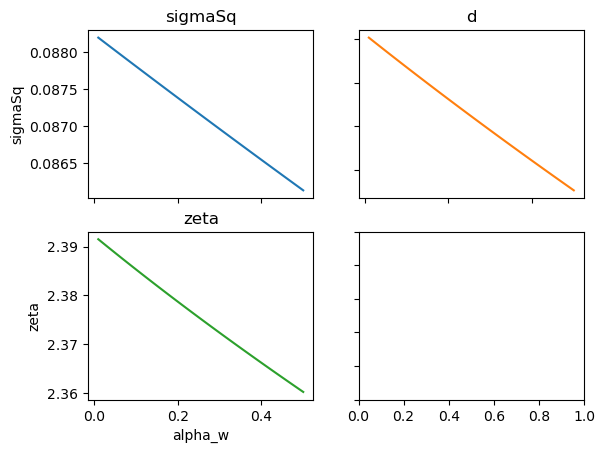

In [84]:
alpha_ws = np.linspace(0.01, 0.5, num=50)

ni = 1000
nj = 1000
V = 500
y_iw = 34
y_jw = 17

sigmaSq = []
d = []
zeta = []

for i, alpha_w in enumerate(alpha_ws):
    alpha_0 = V * alpha_w
    sigmaSq.append(1 / (y_iw + alpha_w) + 1 / ((y_jw + alpha_w)))

    d.append(math.log((y_iw + alpha_w)/(ni + alpha_0 - y_iw - alpha_w)) - \
    math.log((y_jw + alpha_w)/(nj + alpha_0 - y_jw - alpha_w)))

    zeta.append(d[i] / math.sqrt(sigmaSq[i]))

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(alpha_ws, sigmaSq)
axs[0, 0].set_title('sigmaSq')
axs[0, 0].set(xlabel='alpha_w', ylabel='sigmaSq')

axs[0, 1].plot(alpha_ws, d, 'tab:orange')
axs[0, 1].set_title('d')
axs[0, 1].set(xlabel='alpha_w', ylabel='d')

axs[1, 0].plot(alpha_ws, zeta, 'tab:green')
axs[1, 0].set_title('zeta')
axs[1, 0].set(xlabel='alpha_w', ylabel='zeta')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


Now let's make that prior informative by including information about the overall frequency of a given word in a background corpus (i.e., a corpus that represents general word usage, without regard for labeled subcorpora).  To do so, there are only two small changes to make:

* We need to gather a background corpus $b$ and calculate $\hat\pi_w$, the relative frequency of word $w$ in $b$ (i.e., the number of times $w$ occurs in $b$ divided by the number of words in $b$).

* In the uninformative prior above, $\alpha_w$ was a constant (0.01) and $\alpha_0 = V * \alpha_w$.  Let us now set $\alpha_0 = 1000$ and $\alpha_w = \hat\pi_w * \alpha_0$.  This reflects a pseudocount capturing the fractional number of times we would expect to see word $w$ in a sample of 1000 words.

This allows us to specify that a common word like "the" (which has a relative frequency of $\approx 0.04$) would have $\alpha_w = 40$, while an infrequent word like "beneficiaries" (relative frequency $\approx 0.00002$) would have $\alpha_w = 0.02$. 

Q3. Implement a log-odds ratio with informative prior, using a larger background corpus of 5M tokens drawn from the same dataset (given to you as `priors` below, which contains the relative frequencies of words calculated from that corpus) and set $\alpha_0 = 1000$. Using this metric, print out again the 25 words most strongly aligned with the positive corpus, and 25 words most strongly aligned with the negative corpus.  Is there a meaningful difference?

In [85]:
def read_priors(filename):
    counts=Counter()
    freqs={}
    tokens=read_and_tokenize(filename)
    total=len(tokens)

    for token in tokens:
        counts[token]+=1

    for word in counts:
        freqs[word]=counts[word]/total

    return freqs
    
priors=read_priors("../data/sentiment.background.txt")

In [88]:
def logodds_with_informative_prior(one_tokens, two_tokens, priors, display=25):
    
    # complete this section
    alpha_0 = 1000
    ni = len(one_tokens)
    nj = len(two_tokens)
    
    one_counter = Counter(one_tokens)
    two_counter = Counter(two_tokens)
    
    V = len(one_counter) + len(two_counter)
    
    mergedDict = one_counter + two_counter
    
    for key in mergedDict.keys():
        y_iw = one_counter[key]
        y_jw = two_counter[key]
        
        alpha_w = priors[key] * alpha_0
        sigmaSq = 1 / (y_iw + alpha_w) + 1 / ((y_jw + alpha_w))
        
        d = math.log((y_iw + alpha_w)/(ni + alpha_0 - y_iw - alpha_w)) - \
        math.log((y_jw + alpha_w)/(nj + alpha_0 - y_jw - alpha_w))

        mergedDict[key] = d / math.sqrt(sigmaSq)
                                
    pos_aligned = sorted(mergedDict.items(), key=operator.itemgetter(1))[-display:]
    neg_aligned = sorted(mergedDict.items(), key=operator.itemgetter(1))[:display]     
    print("The 25 words most strongly aligned with the positive corpus are:\n")
    print(*pos_aligned, sep = "\n")
    print("The 25 words most strongly aligned with the negative corpus are:\n")
    print(*neg_aligned, sep = "\n")

In [89]:
logodds_with_informative_prior(positive_tokens, negative_tokens, priors)

The 25 words most strongly aligned with the positive corpus are:

('loved', 5.08520207589855)
('tony', 5.151557465549794)
('most', 5.188839322996821)
('beautiful', 5.346392148729829)
('performances', 5.371497571484572)
('always', 5.456154882740344)
('in', 5.477091362874526)
('perfect', 5.540329074257345)
('world', 5.6554566648511475)
('highly', 5.703588456479672)
('life', 5.712104514477569)
('of', 5.754969742770618)
(',', 5.9215701353486665)
('performance', 6.042737335969907)
('her', 6.3771329954200775)
('is', 6.543717647282005)
('wonderful', 6.692625533714691)
('excellent', 7.136307614907904)
('war', 7.2257038478692515)
('love', 7.4541507138623375)
('and', 7.990231407305706)
('as', 8.051850426312377)
('best', 8.207390895133855)
('his', 8.427876598766474)
('great', 9.591039308150844)
The 25 words most strongly aligned with the negative corpus are:

('bad', -15.858436155657074)
('?', -15.012171561204545)
("n't", -11.92973245486743)
('movie', -10.942156841842946)
('worst', -9.95838546446

No, there is no significant difference except the logodds values are slightly different.